<a href="https://colab.research.google.com/github/emilia-uncc/IntroML/blob/main/Assignment6/Homework6_2b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.optim as optim
import torch.nn as nn
from torch.autograd import Variable

from torchvision import datasets
from torchvision import transforms

import datetime

#mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
data_path = '/content/drive/My Drive/DataSets/'
cifar10 = datasets.CIFAR10(data_path,train=True,download=True, transform=transforms.ToTensor())
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True, transform = transforms.ToTensor())


Files already downloaded and verified
Files already downloaded and verified


In [3]:
len(cifar10)

50000

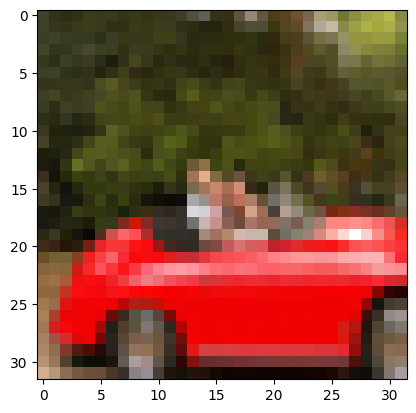

In [4]:
img_t, _ = cifar10[99]
img_t.shape
plt.imshow(img_t.permute(1,2,0))

In [5]:
imgs = torch.stack([img_t for img_t, _ in cifar10], dim=3)
imgs.shape

torch.Size([3, 32, 32, 50000])

In [6]:
imgs.view(3,-1).mean(dim=1)
imgs.view(3,-1).std(dim=1)


tensor([0.2470, 0.2435, 0.2616])

In [7]:
transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2470, 0.2435, 0.2616))

Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.2435, 0.2616))

In [8]:
transformed_cifar10 = datasets.CIFAR10(data_path, train=True,download=False,
                                       transform = transforms.Compose([
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2470, 0.2435, 0.2616))]))
transformed_cifar10_val = datasets.CIFAR10(data_path, train=False,download=False,
                                       transform = transforms.Compose([
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2470, 0.2435, 0.2616))]))

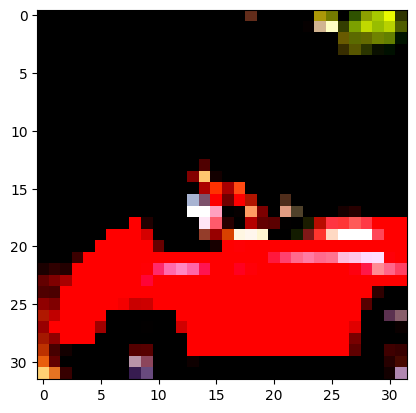

In [9]:
img_t, _ = transformed_cifar10[99]
plt.imshow(img_t.permute(1,2,0))
plt.show()

In [10]:
model = nn.Sequential(nn.Linear(3072, 512),
                      nn.Tanh(),
                      nn.Linear(512, 824),
                      nn.Tanh(),
                      nn.Linear(824, 204),
                      nn.Tanh(),
                      nn.Linear(204, 10),
                      nn.LogSoftmax(dim=1))



In [11]:
loss = nn.NLLLoss()
img, label = transformed_cifar10[99]
out = model(img.view(-1).unsqueeze(0))
loss(out, torch.tensor([label]))

tensor(2.3628, grad_fn=<NllLossBackward0>)

In [12]:
learning_rate = 1e-2
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
train_loader = torch.utils.data.DataLoader(transformed_cifar10, batch_size = 64, shuffle=True)

loss_fn = nn.NLLLoss()
n_epochs = 300
losses = []
start = datetime.datetime.now()
for epoch in range(n_epochs):
  for imgs, labels in train_loader:
    batch_size = imgs.shape[0]
    outputs = model(imgs.view(batch_size, -1))
    loss = loss_fn(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print("Epoch: %d, Loss: %f" % (epoch, float(loss)))
  losses.append(loss.item())

end = datetime.datetime.now()

Epoch: 0, Loss: 1.740884
Epoch: 1, Loss: 1.875553
Epoch: 2, Loss: 1.867289
Epoch: 3, Loss: 1.931316
Epoch: 4, Loss: 1.471240
Epoch: 5, Loss: 1.691248
Epoch: 6, Loss: 1.752934
Epoch: 7, Loss: 1.028951
Epoch: 8, Loss: 1.622739
Epoch: 9, Loss: 1.254174
Epoch: 10, Loss: 1.574593
Epoch: 11, Loss: 1.447330
Epoch: 12, Loss: 1.361003
Epoch: 13, Loss: 1.011914
Epoch: 14, Loss: 1.729976
Epoch: 15, Loss: 1.307480
Epoch: 16, Loss: 1.347102
Epoch: 17, Loss: 1.861007
Epoch: 18, Loss: 1.144588
Epoch: 19, Loss: 1.141729
Epoch: 20, Loss: 0.893153
Epoch: 21, Loss: 0.582399
Epoch: 22, Loss: 0.852239
Epoch: 23, Loss: 0.751255
Epoch: 24, Loss: 0.964421
Epoch: 25, Loss: 0.482929
Epoch: 26, Loss: 0.692149
Epoch: 27, Loss: 0.866320
Epoch: 28, Loss: 0.745461
Epoch: 29, Loss: 0.837107
Epoch: 30, Loss: 0.441467
Epoch: 31, Loss: 0.547904
Epoch: 32, Loss: 0.350692
Epoch: 33, Loss: 0.347153
Epoch: 34, Loss: 0.155035
Epoch: 35, Loss: 0.196920
Epoch: 36, Loss: 0.364984
Epoch: 37, Loss: 0.328635
Epoch: 38, Loss: 1.241

In [17]:
time = end-start
print("Training time: ", str(time))

Training time:  2:14:27.003867


In [14]:
val_loader = torch.utils.data.DataLoader(transformed_cifar10_val, batch_size=64,
  shuffle=False)
correct = 0
total = 0
val_losses = []
with torch.no_grad():
    for imgs, labels in val_loader:
        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1))
        loss = loss_fn(outputs, labels)
        val_losses.append(loss.item())
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
print("Accuracy validation: %f" % (correct / total))


Accuracy validation: 0.452600


In [15]:
#Training set accuracy
train_loader = torch.utils.data.DataLoader(transformed_cifar10, batch_size=64, shuffle=False)
correct = 0
total = 0
with torch.no_grad():
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())

print("Accuracy training: %f" % (correct / total))

Accuracy training: 1.000000


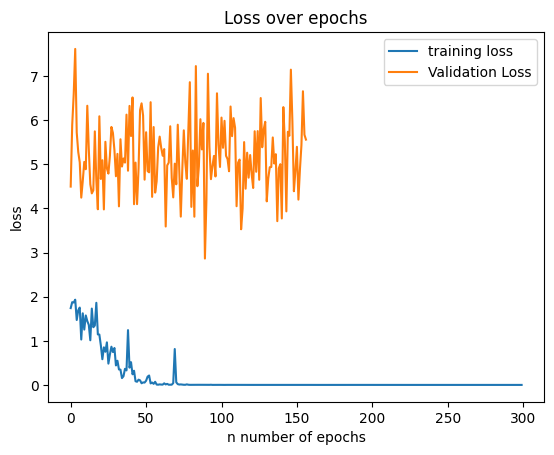

In [16]:
# 4. Plot the training and validation loss after each iteration
plt.plot(losses, label="training loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("n number of epochs")
plt.ylabel("loss")
plt.legend()
plt.title("Loss over epochs")
plt.show()